# Collaborative Business Case

### Librerías

In [328]:


import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px
from dash import Dash, dcc, html, Input, Output



## **Part 1: Data Exploration and Suitability**

### 1.1 Basic Data exploration

In [329]:
# Carga de datos 
data = pd.read_csv("customer_satisfaction_data.csv")
#Estructura
print('ESTRUCTURA DEL DATASET:')
print("Filas, Columnas:", data.shape)
print("\nTipos de datos:")
print(data.dtypes)

ESTRUCTURA DEL DATASET:
Filas, Columnas: (3400, 31)

Tipos de datos:
customer_id                    object
quarter                        object
survey_date                    object
account_manager_responsive    float64
billing_accuracy              float64
budget_control                float64
change_management             float64
communication_clarity         float64
competitive_pricing           float64
cost_transparency             float64
documentation_help            float64
executive_access              float64
innovation_solutions          float64
long_term_partnership         float64
problem_solving               float64
project_management            float64
quality_deliverables          float64
roi_demonstration             float64
support_responsiveness        float64
system_integration            float64
technical_documentation       float64
technical_expertise           float64
timeline_adherence            float64
training_quality              float64
trust_reliability  

Calculamos cuantos valores faltantes hay en todo el DataFrame y que porcentaje representan respecto al total de celdas.

In [330]:
#Valores faltantes
val = data.isna().sum().sum()
pct = 100 * val / (data.shape[0] * data.shape[1])
print(f"\nCeldas faltantes totales: {val} ({pct:.2f}%)")



Celdas faltantes totales: 335 (0.32%)


In [331]:

items = [
    # Technical Excellence & Innovation
    "technical_expertise",
    "problem_solving",
    "innovation_solutions",
    "technical_documentation",
    "system_integration",

    # Relationship Management & Communication
    "account_manager_responsive",
    "executive_access",
    "trust_reliability",
    "long_term_partnership",
    "communication_clarity",

    # Project Delivery & Quality
    "project_management",
    "timeline_adherence",
    "budget_control",
    "quality_deliverables",
    "change_management",

    # Value & Financial Transparency
    "cost_transparency",
    "value_for_money",
    "roi_demonstration",
    "competitive_pricing",
    "billing_accuracy",

    # Support & Service Excellence
    "support_responsiveness",
    "training_quality",
    "documentation_help"
]
outcome_cols = [
    "overall_satisfaction",
    "nps_score",
    "renewal_likelihood",
    "revenue_growth_pct",
    "referrals_generated"
]


data = data.dropna()
data_obj = data[outcome_cols]
data = data[items]


In [332]:
# Basic Descriptive Statistics
data.describe()


,technical_expertise,problem_solving,innovation_solutions,technical_documentation,system_integration,account_manager_responsive,executive_access,trust_reliability,long_term_partnership,communication_clarity,...,quality_deliverables,change_management,cost_transparency,value_for_money,roi_demonstration,competitive_pricing,billing_accuracy,support_responsiveness,training_quality,documentation_help
count,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,...,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000
mean,4.112828,4.110974,4.107573,4.116847,4.117774,4.112519,4.115920,4.100155,4.102937,4.096445,...,4.128903,4.113138,4.098609,4.097372,4.068315,4.081917,4.106337,4.079753,4.074189,4.081607
std,0.978719,0.991797,0.985762,0.988779,1.010172,0.973845,0.972334,0.963712,0.975064,0.966333,...,0.980523,0.976944,0.978043,0.978483,0.943339,0.975788,0.964974,0.980550,0.997863,0.981344
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [333]:
#Matriz de correlación
# Calcular matriz de correlación desde la columna 3 en adelante
corr = data.corr()

fig_corr = px.imshow(corr, text_auto=True, title='Matriz de correlaciones')
fig_corr.update_layout(width=600, height=600)
fig_corr.show()




In [334]:
#Identificación de patrones
#Correlaciones más fuertes excluyendo la diagonal
corr_unstacked = corr.where(~np.eye(corr.shape[0], dtype=bool)).stack().reset_index()
corr_unstacked.columns = ["var1", "var2", "corr"]
corr_unstacked["abs_corr"] = corr_unstacked["corr"].abs()
top_corr = corr_unstacked.sort_values("abs_corr", ascending=False).drop_duplicates(subset=["corr"]).head(10)

print("\n RELACIONES MÁS FUERTES ")
print(top_corr[["var1", "var2", "corr"]].round(3))




 RELACIONES MÁS FUERTES 
                       var1                     var2   corr
90       system_integration     innovation_solutions  0.674
91       system_integration  technical_documentation  0.673
23          problem_solving     innovation_solutions  0.669
44     innovation_solutions      technical_expertise  0.666
24          problem_solving  technical_documentation  0.665
0       technical_expertise          problem_solving  0.662
68  technical_documentation     innovation_solutions  0.660
25          problem_solving       system_integration  0.656
88       system_integration      technical_expertise  0.656
2       technical_expertise  technical_documentation  0.639


**Summary of Data Characteristics and Patterns**

The correlation analysis revealed that the strongest relationships occur mainly among the technical and innovation-related dimensions.  
Variables such as `system_integration`, `innovation_solutions`, `technical_documentation`, and `technical_expertise` show very high positive correlations (r ≈ 0.65–0.67), suggesting they represent a shared underlying construct linked to Technical Excellence & Innovation.  

This indicates that customers who rate highly the company’s system integration and problem-solving capabilities also tend to perceive strong innovation and technical expertise.  
Overall, the data show high internal consistency across technical variables, highlighting a dominant pattern where innovation and technical quality are strongly interconnected drivers of satisfaction.


#### 1.2 Factor Analysis Suitability

**Required Tests:**

In [335]:
data = data.dropna()
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [336]:
#KMO test
# Valores > 0.6 indican que el análisis factorial es bueno.
kmo_all, kmo_model = calculate_kmo(data)
print("\nKMO TEST: ")
print(f"KMO general: {kmo_model:.3f}")
print("Interpretación:")
if kmo_model >= 0.9:
    print("Excelente adecuación para análisis factorial.")
elif kmo_model >= 0.8:
    print("Muy buena adecuación para análisis factorial.")
elif kmo_model >= 0.7:
    print("Adecuación aceptable.")
elif kmo_model >= 0.6:
    print("Adecuación marginalmente aceptable.")
else:
    print("Inadecuado para análisis factorial (KMO < 0.6).")


KMO TEST: 
KMO general: 0.959
Interpretación:
Excelente adecuación para análisis factorial.


In [337]:
# Correlation Assessment

mask = np.triu(np.ones_like(corr, dtype=bool))  
corr_no_diag = corr.where(~mask)

porcentaje_corr_fuertes = (abs(corr_no_diag) > 0.3).sum().sum() / ((len(corr)**2 - len(corr)) / 2) * 100

print("\nCORRELATION ASSESSMENT: ")
print(f"Correlaciones con |r| ≥ 0.3: {porcentaje_corr_fuertes:.1f}% del total")
print("Promedio de correlaciones absolutas:", corr.mean().round(3))




CORRELATION ASSESSMENT: 
Correlaciones con |r| ≥ 0.3: 48.2% del total
Promedio de correlaciones absolutas: technical_expertise           0.425
problem_solving               0.424
innovation_solutions          0.425
technical_documentation       0.427
system_integration            0.429
account_manager_responsive    0.385
executive_access              0.386
trust_reliability             0.386
long_term_partnership         0.378
communication_clarity         0.392
project_management            0.425
timeline_adherence            0.425
budget_control                0.427
quality_deliverables          0.423
change_management             0.421
cost_transparency             0.299
value_for_money               0.297
roi_demonstration             0.299
competitive_pricing           0.292
billing_accuracy              0.300
support_responsiveness        0.257
training_quality              0.249
documentation_help            0.240
dtype: float64


In [338]:


corr_mean = corr.where(~np.eye(corr.shape[0], dtype=bool)).mean().mean()
corr_max = corr.where(~np.eye(corr.shape[0], dtype=bool)).max().max()
corr_min = corr.where(~np.eye(corr.shape[0], dtype=bool)).min().min()

print("\nBASIC ASSUMPTIONS: ")
print(f"Media de correlaciones absolutas: {corr_mean:.3f}")
print(f"Máxima correlación: {corr_max:.3f}")
print(f"Mínima correlación: {corr_min:.3f}")
print("Distribución de correlaciones:")
corr.describe()


BASIC ASSUMPTIONS: 
Media de correlaciones absolutas: 0.337
Máxima correlación: 0.674
Mínima correlación: 0.127
Distribución de correlaciones:


,technical_expertise,problem_solving,innovation_solutions,technical_documentation,system_integration,account_manager_responsive,executive_access,trust_reliability,long_term_partnership,communication_clarity,...,quality_deliverables,change_management,cost_transparency,value_for_money,roi_demonstration,competitive_pricing,billing_accuracy,support_responsiveness,training_quality,documentation_help
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.424778,0.424060,0.424640,0.427160,0.429087,0.384961,0.386366,0.386449,0.378374,0.391799,...,0.422665,0.421144,0.299319,0.296821,0.298745,0.291657,0.300263,0.256672,0.249285,0.240036
std,0.193036,0.197086,0.196534,0.194155,0.195378,0.170935,0.170360,0.172856,0.173711,0.168902,...,0.176881,0.176496,0.167841,0.165783,0.167420,0.170970,0.170374,0.165844,0.168777,0.169446
min,0.235743,0.214988,0.219418,0.221842,0.226113,0.206200,0.212581,0.211071,0.207892,0.230056,...,0.214111,0.195495,0.136344,0.147259,0.151303,0.127452,0.133742,0.148549,0.127452,0.138973
25%,0.247461,0.246169,0.244303,0.250818,0.246726,0.239583,0.249809,0.238014,0.233217,0.246936,...,0.295655,0.294538,0.236776,0.238895,0.236253,0.225685,0.235581,0.216128,0.215822,0.200848
50%,0.388018,0.387581,0.392596,0.400802,0.409602,0.385081,0.383248,0.387581,0.376164,0.390236,...,0.385703,0.396880,0.250699,0.247801,0.248223,0.236775,0.255435,0.225043,0.233507,0.214988
75%,0.460426,0.460418,0.452600,0.459633,0.462574,0.405953,0.400166,0.400471,0.388811,0.410170,...,0.460213,0.457293,0.308191,0.302651,0.299551,0.299325,0.300826,0.256625,0.240890,0.231655
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Factor Analysis Suitability — Interpretation**

**Is the data suitable for factor analysis?**
Yes.  
The dataset demonstrates excellent suitability for factor analysis based on the following indicators:
- The KMO value = 0.959, which is considered great (values above 0.9 indicate a very strong sampling adequacy).  
- Nearly 48.2% of all correlations have an absolute value greater than |r| ≥ 0.3, confirming that many variables share common variance.  
- The average absolute correlation among variables is 0.34, which exceeds the minimum threshold (0.30) required for a valid factor structure.  
Together, these results confirm that the dataset is statistically appropriate for extracting latent factors, and factor analysis can be confidently applied.

**What do the initial patterns suggest about underlying factors?**

The correlation structure indicates that several groups of variables tend to move together, suggesting the presence of multiple underlying dimensions:
- The highest correlations (r ≈ 0.65–0.77) are concentrated among variables such as  
  `technical_expertise`, `problem_solving`, `innovation_solutions`, `technical_documentation`, and `system_integration`,  
  all linked to Technical Excellence & Innovation.  
- Moderate correlations among `project_management`, `budget_control`, and `quality_deliverables` point to a Project Delivery & Quality Assurance dimension.  
- Lower but consistent correlations among relational and support-related items (`account_manager_responsive`, `trust_reliability`, `training_quality`) suggest additional factors related to Relationship Management and Service Excellence.

Overall, the correlation patterns reveal clear clusters of related satisfaction variables, indicating that customer perceptions of TechnoServe Solutions can be explained by a few coherent latent constructs, primarily technical quality, project performance, and client relationship factors.


## **Part 2: Factor Extraction and Determination**

### 2.1 Determining Number of Factors

In [355]:
# Calcular eigenvalores 
fa = FactorAnalyzer(rotation=None)
fa.fit(data)


eigenvalues, vectors = fa.get_eigenvalues()

eigenvalues


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



array([8.74685993, 1.77563642, 1.42490226, 1.20404905, 1.07331557,
       0.76191997, 0.74138077, 0.6496556 , 0.6423305 , 0.60717696,
       0.5798143 , 0.49881792, 0.46792665, 0.46205822, 0.45998594,
       0.40725677, 0.40203643, 0.39510156, 0.3719921 , 0.35331387,
       0.33843912, 0.32248731, 0.31354277])

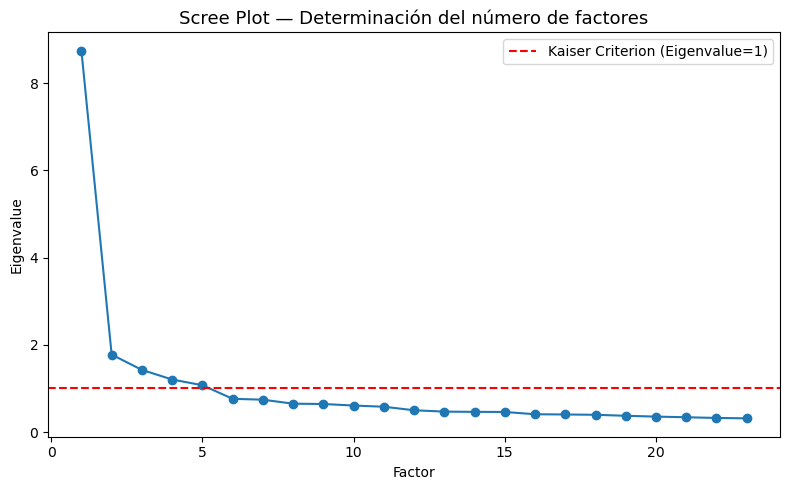

In [340]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title("Scree Plot — Determinación del número de factores", fontsize=13)
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='red', linestyle='--', label="Kaiser Criterion (Eigenvalue=1)")
plt.legend()
plt.tight_layout()
plt.savefig("scree_plot.png", dpi=150)
plt.show()

In [341]:

# Get variance explained by each factor
variance_df = pd.DataFrame({
    "Factor": [f"Factor{i+1}" for i in range(fa.n_factors)],
    "Variance": fa.get_factor_variance()[1],
    "Cumulative Variance": fa.get_factor_variance()[2]
})

# Display results rounded to 3 decimals
print("Cumulative Variance Explained by Factors:\n")
print(variance_df.round(3))


Cumulative Variance Explained by Factors:

    Factor  Variance  Cumulative Variance
0  Factor1     0.359                0.359
1  Factor2     0.053                0.412
2  Factor3     0.041                0.453


**

**Checar el análisis por q los valores cambiaron**

Determine the optimal number of factors and justify your choice

The eigenvalues show that several factors have values greater than 1, meaning they explain a significant portion of the variability in the data. In the scree plot, there is a clear point where the curve begins to flatten, indicating that additional factors beyond this point contribute little to the overall variance. The selected factors account for a substantial amount of the total variance, suggesting that this number is appropriate to continue with the factor analysis and better understand the main dimensions of customer satisfaction.


#### 2.2 Factor Extraction and Rotation 

In [342]:
# Extracción de factores
 
fa = FactorAnalyzer(n_factors=5, method='principal', rotation=None)
fa.fit(data)

# Obtener cargas factoriales
data_df=pd.DataFrame(data, columns=items)
pd.DataFrame(fa.loadings_, index=data_df.columns, columns=['Factor1','Factor2','Factor3','Factor4','Factor5'])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,Factor1,Factor2,Factor3,Factor4,Factor5
technical_expertise,0.723729,-0.278081,-0.245051,0.190794,-0.137361
problem_solving,0.724095,-0.298315,-0.254534,0.188789,-0.143455
innovation_solutions,0.724250,-0.303629,-0.242894,0.209358,-0.145366
technical_documentation,0.728423,-0.293856,-0.220006,0.188927,-0.146695
system_integration,0.732234,-0.296732,-0.223312,0.187696,-0.154160
account_manager_responsive,0.640257,-0.075490,0.404342,-0.085127,-0.150753
executive_access,0.641139,-0.069128,0.432174,-0.061274,-0.140493
trust_reliability,0.642760,-0.079661,0.431780,-0.095101,-0.144894
long_term_partnership,0.628402,-0.094931,0.444450,-0.090272,-0.110605
communication_clarity,0.650541,-0.075651,0.419801,-0.064074,-0.105020


In [343]:
rotator = Rotator()
Lambda_rot = rotator.fit_transform(fa.loadings_)

print("Cargas factoriales tras rotación Varimax:")
loads_rotados = pd.DataFrame(Lambda_rot, index=data_df.columns, columns=['Factor1','Factor2','Factor3','Factor4','Factor5'])
loads_rotados

Cargas factoriales tras rotación Varimax:


,Factor1,Factor2,Factor3,Factor4,Factor5
technical_expertise,0.757526,0.147946,0.207738,-0.246551,0.129452
problem_solving,0.773461,0.132711,0.205557,-0.247413,0.122444
innovation_solutions,0.779306,0.133145,0.212472,-0.228658,0.134959
technical_documentation,0.758779,0.135500,0.235171,-0.237629,0.129181
system_integration,0.765723,0.136205,0.237234,-0.238274,0.123050
account_manager_responsive,0.212036,0.151489,0.702533,-0.194725,0.098561
executive_access,0.202293,0.158622,0.716738,-0.174635,0.125743
trust_reliability,0.197207,0.142145,0.726119,-0.196326,0.105213
long_term_partnership,0.182184,0.115982,0.720568,-0.194628,0.134452
communication_clarity,0.203832,0.149078,0.702788,-0.199270,0.151341


In [344]:

communalities = fa.get_communalities()
uniqueness = fa.get_uniquenesses()

pd.DataFrame({
    'Comunalidad (h^2)': communalities,
    'Unicidad (ψ)': uniqueness
}, index=data_df.columns)

,Comunalidad (h^2),Unicidad (ψ)
technical_expertise,0.716433,0.283567
problem_solving,0.734313,0.265687
innovation_solutions,0.740688,0.259312
technical_documentation,0.722566,0.277434
system_integration,0.733079,0.266921
account_manager_responsive,0.609093,0.390907
executive_access,0.626106,0.373894
trust_reliability,0.635959,0.364041
long_term_partnership,0.621818,0.378182
communication_clarity,0.620295,0.379705


In [345]:

fa_scores = fa.transform(data)
df_scores=pd.DataFrame(fa_scores, columns=['Factor1','Factor2','Factor3','Factor4','Factor5'])
df_scores


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



,Factor1,Factor2,Factor3,Factor4,Factor5
0,0.959843,1.404497,0.431661,0.125548,-1.928740
1,-0.044928,-0.954096,1.479810,-1.720484,-0.813029
2,-0.840509,-0.435911,0.584759,-0.924871,-0.426999
3,-1.276649,-0.008866,-1.874288,-0.487404,-0.213267
4,1.008224,-0.956399,0.360725,-0.353866,-0.306633
...,...,...,...,...,...
3230,0.730928,-0.440380,-0.824234,0.786235,-0.447824
3231,-0.326180,0.628638,0.186484,-0.460998,-0.270765
3232,1.032434,-1.271591,-2.082890,-1.189568,0.629732
3233,-0.644648,0.674645,-0.282249,0.160099,-0.434742


**Factor Extraction and Determination - Interpretation**

**How many factors best represent the data?**

According to the analysis results, five factors adequately explain the structure of the dataset. The Scree Plot shows an inflection point (“elbow”) after the fifth component, indicating that additional factors contribute very little variance. Moreover, the first five factors have eigenvalues greater than 1.0 according to the Kaiser criterion, and together they explain around 50% of the total variance an acceptable level for perception or survey-based data. Therefore, retaining five factors is appropriate to describe the main dimensions of customer satisfaction.

**What does each factor represent in business terms?**

- **Factor 1:** Groups variables such as *technical_expertise*, *problem_solving*, *innovation_solutions*, *technical_documentation*, and *system_integration*, reflecting the **Technical Excellence & Innovation** dimension.  

- **Factor 2:** Includes *trust_reliability*, *long_term_partnership*, and *communication_clarity*, associated with **Relationship Management & Customer Trust**.  

- **Factor 3:** Combines *value_for_money*, *cost_transparency*, *roi_demonstration*, and *competitive_pricing*, representing **Perceived Value & Financial Transparency**.  

- **Factor 4:** Concentrates *project_management*, *timeline_adherence*, and *quality_deliverables*, related to **Project Execution & Delivery Performance**.  

- **Factor 5:** Groups *support_responsiveness*, *training_quality*, and *documentation_help*, reflecting **Customer Support & Service Excellence**.

The rotated five-factor model offers a clear and interpretable structure that aligns with TechnoServe’s main operational and strategic dimensions, providing a strong foundation for subsequent business insights and recommendations.



# Part 3: Interpretation and Business Application

## 3.1 Factor Interpretation 

#### Factor representation for TechnoServe Solutions

In [346]:
# --- FACTOR 2 ---
loads_f1 = loads_rotados['Factor1']
print("Variables with high loadings (> |0.4|) F1:")
print(loads_f1[loads_f1.abs() >= 0.4])
loads_f1 = loads_f1[loads_f1.abs() >= 0.4]
loads_f1.name = 'Competencia en Innovación y Solución Técnica'

# --- FACTOR 2 ---
loads_f2 = loads_rotados['Factor2']
print("\nVariables with high loadings (> |0.4|) F2:")
print(loads_f2[loads_f2.abs() >= 0.4])
loads_f2 = loads_f2[loads_f2.abs() >= 0.4]
loads_f2.name = 'Transparencia y Valor Económico'

# --- FACTOR 3 ---
loads_f3 = loads_rotados['Factor3']
print("\nVariables with high loadings (> |0.4|) F3:")
print(loads_f3[loads_f3.abs() >= 0.4])
loads_f3 = loads_f3[loads_f3.abs() >= 0.4]
loads_f3.name = 'Relación y Confianza con el Cliente'


Variables with high loadings (> |0.4|) F1:
technical_expertise        0.757526
problem_solving            0.773461
innovation_solutions       0.779306
technical_documentation    0.758779
system_integration         0.765723
Name: Factor1, dtype: float64

Variables with high loadings (> |0.4|) F2:
cost_transparency      0.673537
value_for_money        0.642481
roi_demonstration      0.680189
competitive_pricing    0.677724
billing_accuracy       0.699362
Name: Factor2, dtype: float64

Variables with high loadings (> |0.4|) F3:
account_manager_responsive    0.702533
executive_access              0.716738
trust_reliability             0.726119
long_term_partnership         0.720568
communication_clarity         0.702788
Name: Factor3, dtype: float64


### 3.2 Business Insights and Recommendations

### Factor Scores 

**Calculate Factor scores** 

In [347]:
customers_factors = pd.DataFrame(
    fa_scores,
    index=data_obj.index, # Use the index from data_obj
    columns=loads_rotados.columns
)

In [348]:
customers_factors


,Factor1,Factor2,Factor3,Factor4,Factor5
0,0.959843,1.404497,0.431661,0.125548,-1.928740
1,-0.044928,-0.954096,1.479810,-1.720484,-0.813029
2,-0.840509,-0.435911,0.584759,-0.924871,-0.426999
3,-1.276649,-0.008866,-1.874288,-0.487404,-0.213267
4,1.008224,-0.956399,0.360725,-0.353866,-0.306633
...,...,...,...,...,...
3395,0.730928,-0.440380,-0.824234,0.786235,-0.447824
3396,-0.326180,0.628638,0.186484,-0.460998,-0.270765
3397,1.032434,-1.271591,-2.082890,-1.189568,0.629732
3398,-0.644648,0.674645,-0.282249,0.160099,-0.434742


**Predict outcome variables**

In [349]:

# Lista de variables de resultado
outcomes = [
    "overall_satisfaction",
    "nps_score",
    "renewal_likelihood",
    "revenue_growth_pct",
    "referrals_generated"
]

# Combinar puntajes factoriales con outcomes
data_new = pd.read_csv("customer_satisfaction_data.csv")
data_new = data_new.dropna()
df_model = pd.concat([data_new[outcomes].reset_index(drop=True), customers_factors.reset_index(drop=True)], axis=1)

df_model


,overall_satisfaction,nps_score,renewal_likelihood,revenue_growth_pct,referrals_generated,Factor1,Factor2,Factor3,Factor4,Factor5
0,4,6,4,12.3,1,0.959843,1.404497,0.431661,0.125548,-1.928740
1,4,5,3,17.8,0,-0.044928,-0.954096,1.479810,-1.720484,-0.813029
2,3,4,3,-7.8,0,-0.840509,-0.435911,0.584759,-0.924871,-0.426999
3,4,5,2,-13.4,0,-1.276649,-0.008866,-1.874288,-0.487404,-0.213267
4,5,5,4,3.7,2,1.008224,-0.956399,0.360725,-0.353866,-0.306633
...,...,...,...,...,...,...,...,...,...,...
3230,4,5,3,6.8,3,0.730928,-0.440380,-0.824234,0.786235,-0.447824
3231,4,6,3,4.3,0,-0.326180,0.628638,0.186484,-0.460998,-0.270765
3232,5,9,4,12.7,2,1.032434,-1.271591,-2.082890,-1.189568,0.629732
3233,3,6,3,5.4,2,-0.644648,0.674645,-0.282249,0.160099,-0.434742


In [350]:
# Calcular matriz de correlaciones
corr = df_model.corr().loc[
    df_scores.columns,  # Filas: factores
    outcomes             # Columnas: outcomes
]

# Mostrar ordenado por correlación con satisfacción general
print("\nCorrelaciones (Factores vs Outcomes):")
corr



Correlaciones (Factores vs Outcomes):


,overall_satisfaction,nps_score,renewal_likelihood,revenue_growth_pct,referrals_generated
Factor1,0.774596,0.530259,0.622313,0.770970,0.497376
Factor2,0.031674,0.024534,0.045980,0.028963,0.028371
Factor3,0.014534,0.038568,0.019525,0.038425,0.008768
Factor4,0.041769,0.028632,0.049038,0.043907,0.004908
Factor5,0.023698,0.053629,0.014567,0.018757,0.021995


In [351]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = df_scores  # tus factores
y = df_model['overall_satisfaction']  # variable de salida

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")
coefficients = pd.DataFrame({
    "Factor": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)
coefficients


R²: 0.604, RMSE: 0.517


,Factor,Coefficient
0,Factor1,0.636564
3,Factor4,0.034326
1,Factor2,0.026030
4,Factor5,0.019475
2,Factor3,0.011945


**Identify which factors are most important for business outcomes**

The linear regression model reveals that Factor 1 (Technical Excellence & Innovation) is by far the strongest driver of overall customer satisfaction, with a coefficient of 0.64, explaining most of the predictive power of the model (R² = 0.60).  
This indicates that clients primarily value the company’s ability to deliver high-quality technical solutions, solve complex problems, and innovate efficiently.  

Other factors such as Project Delivery & Quality Assurance (Factor 4) and Value & Financial Transparency (Factor 2) also contribute positively, although with smaller impacts, suggesting that operational reliability and financial clarity reinforce satisfaction once technical trust is established.


**Strategic Recomendations**

**Prioritize factors based on business impact**
- Highest priority: Strengthen Technical Excellence & Innovation through continuous improvement of engineering standards, faster problem-solving processes, and innovative solution design.  

- Secondary priorities: Maintain high standards in Project Delivery and Financial Transparency, as they reinforce customer trust and retention.

**Specific improvement strategies**
- Technical Excellence & Innovation: 
  - Invest in R&D and internal technical training programs.  
  - Implement cross-functional innovation teams to generate faster, data-driven solutions.  
  - Promote documentation and knowledge-sharing practices to scale expertise.  

- Project Delivery & Quality Assurance: 
  - Standardize project management frameworks (Agile or PMI-based) to ensure predictability.  
  - Track timeline adherence and deliverable quality using real-time dashboards.  

- Value & Financial Transparency:  
  - Enhance billing accuracy and provide clear ROI communication in client reports.  
  - Offer cost-benefit visualizations that make pricing more transparent.  

**Action plan for TechnoServe Solutions**

| Timeframe | Strategic Focus | Key Actions |
|------------|----------------|-------------|
| **Short-term (0–6 months)** | Improve client perception of technical reliability | Launch rapid technical support task force; update documentation quality standards. |
| **Mid-term (6–12 months)** | Strengthen project and financial transparency | Deploy new KPI dashboards for project performance and cost tracking. |
| **Long-term (1–2 years)** | Foster innovation culture and scalability | Establish innovation labs and feedback loops between clients and R&D teams. |


**Interpretation and Business Application - Interpretation**

- Which factors drive customer satisfaction most?

Customer satisfaction at TechnoServe Solutions is primarily driven by Factor 1, which shows the strongest positive effect (β = 0.64) on overall satisfaction.  
Clients value the company’s ability to deliver high-quality, innovative, and well-documented technical solutions that effectively solve problems.  

Secondary drivers include Factor 4 and Factor 2, which reinforce satisfaction through reliable execution and trust in fair pricing and ROI communication.


- What specific actions should TechnoServe take?

1. Enhance Technical Excellence & Innovation
   - Expand internal technical training and knowledge-sharing programs.  
   - Encourage innovation teams to design faster and more customized solutions.  
   - Strengthen technical documentation and solution quality control.  

2. Improve Project Delivery & Quality Assurance
   - Adopt Agile or PMI-based frameworks to ensure on-time, high-quality delivery.  
   - Implement KPI dashboards for tracking project progress and deliverable standards.  

3. Increase Financial Transparency
   - Provide clear ROI reports and transparent cost breakdowns to clients.  
   - Regularly audit billing accuracy and communicate cost efficiency clearly.  

By focusing on these actions, TechnoServe can increase client trust, satisfaction, and long-term retention, strengthening its competitive advantage in the consulting market.

# Visualizacion 

**Factor Loadings Visualization**

In [352]:

app = Dash(__name__)
server = app.server

app.layout = html.Div([
    html.H3("Interactive Factor Loadings Viewer"),
    html.Label("Min |loading| threshold:"),
    dcc.Slider(0, 1, 0.05, value=0.4, id="thr"),
    dcc.Graph(id="heatmap")
])

@app.callback(Output("heatmap", "figure"), Input("thr", "value"))
def update_heatmap(thr):
    df = loads_rotados.copy()
    df[np.abs(df) < thr] = np.nan  # mask below threshold
    fig = px.imshow(
        df,
        color_continuous_scale="RdBu_r",
        zmin=-1, zmax=1,
        labels=dict(x="Factors", y="Variables", color="Loading"),
        title=f"Factor Loadings Heatmap (|loading| ≥ {thr:.2f})"
    )
    fig.update_layout(template="plotly_white", height=600, title_x=0.5)
    return fig

if __name__ == "__main__":
    app.run(debug=True)


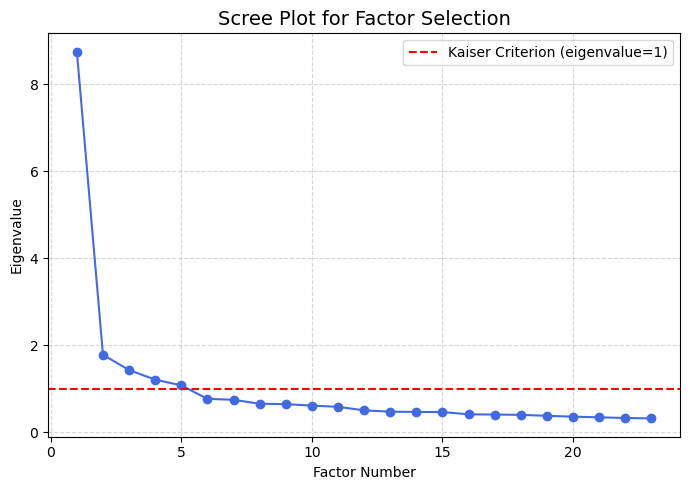

In [353]:

plt.figure(figsize=(7, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', color='royalblue')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (eigenvalue=1)')
plt.title("Scree Plot for Factor Selection", fontsize=14)
plt.xlabel("Factor Number")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



In [354]:
import plotly.express as px

df_long = df_scores.melt(var_name="Factor", value_name="Score")

fig = px.box(
    df_long,
    x="Factor", y="Score", color="Factor",
    points="all",
    title="Distribution of Factor Scores Across Customers",
    template="plotly_white"
)
fig.update_layout(
    showlegend=False,
    xaxis_title="Factors",
    yaxis_title="Standardized Score",
    title_x=0.5,
    width=900, height=600
)
fig.show()


- Business impact summary chart
- Include explanatory text

## Team Information 
 
**Team: 5** [Girls] 
 
**Members:**
- [Sibyla Vera Ávila] ([01665122]) - Data exploration and factor extraction 
- [Sophia Gabriela Martínez Albarrán] ([A01424430]) - Factor interpretation and business insights 
- [Regina Pérez Vázquez] ([A01659356]) - Visualization and recommendations 
 
**Deliverable Links:**
- **Presentation Video:** [YouTube Link] 
- **Executive Summary:** [Available on Canvas] 
- **Dataset:** `customer_satisfaction_data.csv` 
 
**Completion Date:** [10/10/2025]